#Рубежный контроль №2

Исполнитель: Жизневский Павел ИУ5-21М

## Задание

Необходимо решить задачу классификации текстов на основе любого выбранного Вами датасета (кроме примера, который рассматривался в лекции). Классификация может быть бинарной или многоклассовой. Целевой признак из выбранного Вами датасета может иметь любой физический смысл, примером является задача анализа тональности текста.

## Решение

### Импорт библотек

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Загрузка датасета

Загрузка csv файла в colab

Датасет - отзывы клиентов о женской одежде. В качестве целевого признака используем название класса одежды.

In [2]:
text = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
text.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [5]:
print(text['Class Name'].unique())
print(len(text['Class Name'].unique()))

['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' nan 'Chemises']
21


21 уникальное значение - виды одежды, по которым составлен отзыв.

In [0]:
text = text.dropna()

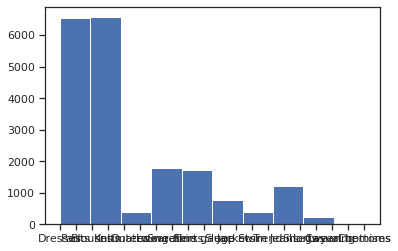

<Figure size 432x288 with 0 Axes>

In [19]:
plt.hist(text['Class Name'])
plt.show()
plt.figure().savefig('graph.png')

Сформируем общий словарь для обучения моделей из обучающей и тестовой выборки

In [0]:
vocab_list = text['Review Text'].tolist()

In [11]:
vocabVect = CountVectorizer()
vocabVect.fit(vocab_list)
corpusVocab = vocabVect.vocabulary_
print('Количество сформированных признаков - {}'.format(len(corpusVocab)))

Количество сформированных признаков - 13575


In [12]:
tfidfv = TfidfVectorizer(ngram_range=(1,3))
tfidf_ngram_features = tfidfv.fit_transform(vocab_list)
tfidf_ngram_features

<19662x814252 sparse matrix of type '<class 'numpy.float64'>'
	with 3011751 stored elements in Compressed Sparse Row format>

### Сравнение классификаторов

In [0]:
X_train, X_test, y_train, y_test = train_test_split(text['Review Text'], text['Class Name'], test_size=0.5, random_state=1)

Используем метрики качества balanced_accuracy и матрицу ошибок.

In [0]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        temp_data_flt = df[df['t']==c]
        temp_acc = balanced_accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))
    


In [0]:
def sentiment(v, c):
    model = Pipeline(
        [("vectorizer", v), 
         ("classifier", c)])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Accuracy
    print_accuracy_score_for_classes(y_test, y_pred)
    
    # Матрица ошибок
    fig, ax = plt.subplots( figsize=(15,5))
    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, ax=ax)

def result_table():
  classifiers = (LogisticRegression(),KNeighborsClassifier(n_neighbors=6),MultinomialNB(), ComplementNB())
  rows = text['Class Name'].unique()
  cols = ('LogisticRegression', 'KNeighbors', 'MultinomialNB', 'ComplementNB')
  data = []
  for c in classifiers:
      classifier_data = []
      model = Pipeline(
        [("vectorizer", TfidfVectorizer(ngram_range=(1,4))), 
         ("classifier", c)])
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      accs = accuracy_score_for_classes(y_test, y_pred)
      for i in accs:
        classifier_data.append(accs[i])
      data.append(classifier_data)
  table = plt.table(cellText=data, colLabels=cols, rowLabels=rows, loc='center')
  plt.show()
  # print(data)
  # fig, axs = plt.subplots(2,1)
  # for col in cols:
  #   for row in rows:



In [0]:
# result_table()

Логистическая регрессия

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
Blouses 	 0.3359497645211931
Chemises 	 0.0
Dresses 	 0.9618800888230941
Fine gauge 	 0.0022727272727272726
Intimates 	 0.0
Jackets 	 0.05825242718446602
Jeans 	 0.7086776859504132
Knits 	 0.7503700049333991
Layering 	 0.0
Legwear 	 0.0
Lounge 	 0.0
Outerwear 	 0.007194244604316547
Pants 	 0.5493716337522442
Shorts 	 0.0072992700729927005
Skirts 	 0.4557291666666667
Sleep 	 0.0
Sweaters 	 0.35313001605136435
Swim 	 0.0
Trend 	 0.0


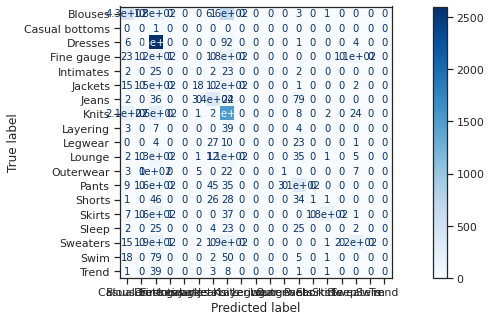

In [25]:
sentiment(TfidfVectorizer(ngram_range=(1,4)), LogisticRegression())

К ближайших соседей

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
Blouses 	 0.3414442700156986
Chemises 	 0.0
Dresses 	 0.7472242783123613
Fine gauge 	 0.09545454545454546
Intimates 	 0.05555555555555555
Jackets 	 0.10679611650485436
Jeans 	 0.5702479338842975
Knits 	 0.3892451899358658
Layering 	 0.018867924528301886
Legwear 	 0.16923076923076924
Lounge 	 0.030716723549488054
Outerwear 	 0.07913669064748201
Pants 	 0.2639138240574506
Shorts 	 0.12408759124087591
Skirts 	 0.171875
Sleep 	 0.04938271604938271
Sweaters 	 0.09470304975922954
Swim 	 0.2064516129032258
Trend 	 0.0


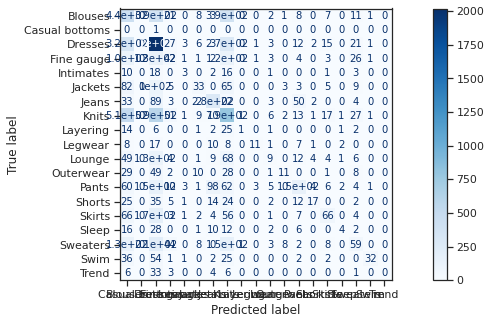

In [24]:
sentiment(TfidfVectorizer(ngram_range=(1,4)), KNeighborsClassifier(n_neighbors=6))

Multinomial Naive Bayes

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
Blouses 	 0.0031397174254317113
Chemises 	 0.0
Dresses 	 0.9918578830495929
Fine gauge 	 0.0
Intimates 	 0.0
Jackets 	 0.0
Jeans 	 0.02066115702479339
Knits 	 0.4662062160828811
Layering 	 0.0
Legwear 	 0.0
Lounge 	 0.0
Outerwear 	 0.0
Pants 	 0.010771992818671455
Shorts 	 0.0
Skirts 	 0.0
Sleep 	 0.0
Sweaters 	 0.0
Swim 	 0.0
Trend 	 0.0


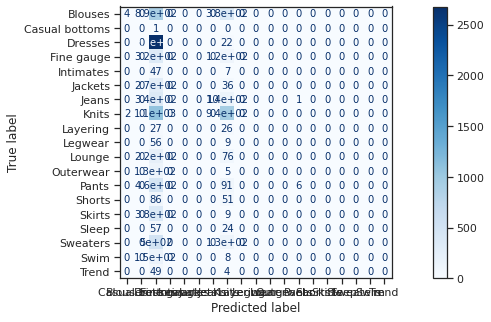

In [26]:
sentiment(TfidfVectorizer(), MultinomialNB())

Complement Naive Bayes

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Метка 	 Accuracy
Blouses 	 0.25353218210361067
Chemises 	 0.0
Dresses 	 0.9426350851221318
Fine gauge 	 0.06818181818181818
Intimates 	 0.09259259259259259
Jackets 	 0.2815533980582524
Jeans 	 0.8367768595041323
Knits 	 0.6679822397631968
Layering 	 0.03773584905660377
Legwear 	 0.1076923076923077
Lounge 	 0.07167235494880546
Outerwear 	 0.302158273381295
Pants 	 0.5888689407540395
Shorts 	 0.17518248175182483
Skirts 	 0.4192708333333333
Sleep 	 0.16049382716049382
Sweaters 	 0.4189406099518459
Swim 	 0.7354838709677419
Trend 	 0.0


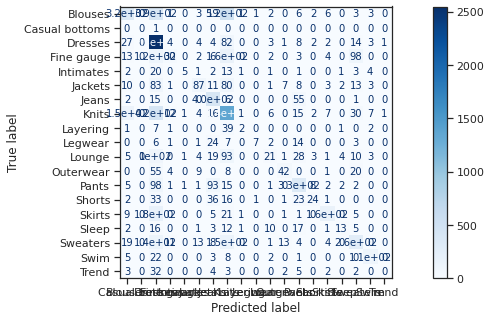

In [27]:
sentiment(TfidfVectorizer(), ComplementNB())

## Вывод

Наиболее качественную классификацию осуществил классификатор Multinomial Naive Bayes (~99%). Из других классификаторов наиболее качественне результаты показал метод логистической регрессии (96%).